In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy import sparse
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython import display

# Explicit FTCS

In [3]:
def max_stable_timestep(dx, D):
    return dx**2 / (2 * D)

In [4]:
def do_step_FTCS(p, j, D, dx, dt, f):
    return p[j] + (D * dt / dx ** 2) * (p[j+1] - 2 * p[j] + p[j-1]) + dt * f[j]

In [5]:
def solve_loop(psi, s, dx, dt, D):
    p = np.copy(psi)
    start = time.time()
    iters = 0
    time_diffuse = 0
    while not np.isclose(p[0], p[-1]):
        for i in range(1, p.size-1):
            p[i] = do_step_FTCS(p, i, D, dx, dt, s)
        p[-1] = p[-2]
        iters += 1
        time_diffuse += dt
    return p, iters, time_diffuse, (time.time() - start)

In [6]:
# Solve the diffusion equation using the explicit FTCS scheme
# Find how long it takes a toxic fluid entering a 1D tube of 1 meter to go from one end to the other.
D = 1
L = 1
nx = 100
s = np.zeros(nx)
s[0] = 100
psi = np.copy(s)
dx = L / nx
dt = max_stable_timestep(dx, 2)
# dt = dx
print(f'Max stable timestep is {dt}')

Max stable timestep is 2.5e-05


In [7]:
# Solve psi with a for loop
psi_for, iters_for, time_for_diffuse, time_for_run = solve_loop(psi, s, dx, dt, D)

Took 22.0356 seconds to run
Took 3.477124999995231 seconds to diffuse
Ran 139085 iterations


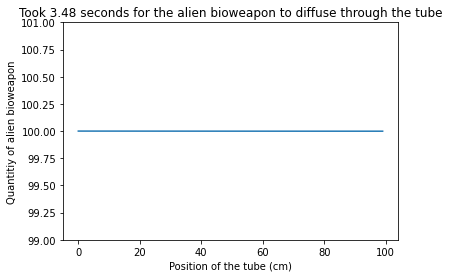

In [8]:
print(f'Took {time_for_run:.4f} seconds to run')
print(f'Took {time_for_diffuse} seconds to diffuse')
print(f'Ran {iters_for} iterations')

plt.plot(range(psi_for.size), psi_for)
plt.ylim((99, 101))
plt.title(f'Took {time_for_diffuse:.2f} seconds for the alien bioweapon to diffuse through the tube')
plt.ylabel('Quantitiy of alien bioweapon')
plt.xlabel('Position of the tube (cm)')
plt.show()

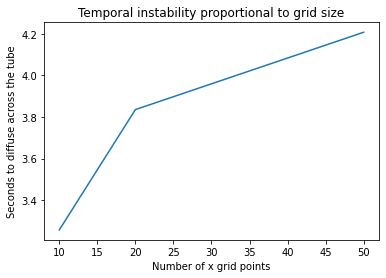

In [15]:
# Examine the diffusion time for different numbers of x grid points
grid_sample = [10, 20, 50]
diffusion_times = []
for nx in grid_sample:
    s = np.zeros(nx)
    s[0] = 100
    psi = np.copy(s)
    dx = L / nx
    dt = max_stable_timestep(dx, 2) / 4
    
    # Solve psi with a for loop
    psi_for, iters_for, time_for_diffuse, time_for_run = solve_loop(psi, s, dx, dt, D)
    
    diffusion_times.append(time_for_diffuse)
    
plt.plot(grid_sample, diffusion_times)
plt.title('Temporal instability proportional to grid size')
plt.xlabel('Number of x grid points')
plt.ylabel('Seconds to diffuse across the tube')
plt.show()

# Excercise 5 Diffusion and Parabolic Equations

0.0022222222222222222


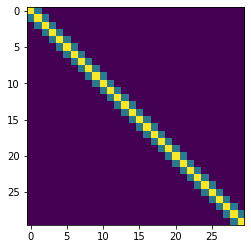

In [23]:
# Define the domain
x_start = -1
x_end = 1
x = x_end - x_start
Nx = 30
dx = x / Nx

max_dt = max_stable_timestep(dx, D)
print(max_dt)
dt = 1e-3
time_bounds = [0, 1]

D = 1
s = np.ones(Nx)

g0 = 1 - (2 * D * dt / np.square(dx))
g_ = D * dt / np.square(dx)
G = sparse.diags([g_, g0, g_], [-1, 0, 1], shape=[Nx, Nx])

# What does this G matrix look like?
plt.imshow(G.toarray())
plt.show()

In [24]:
# Solve for the given conditions above with dt = 1e-2
def solve_phi(Nx, time_bounds, dt, dx, s):
    Nt = int((time_bounds[1] - time_bounds[0]) / dt)
    phi = np.zeros([Nx, Nt])
    
    g0 = 1 - (2 * D * dt / np.square(dx))
    g_ = D * dt / np.square(dx)
    G = sparse.diags([g_, g0, g_], [-1, 0, 1], shape=[Nx, Nx])
    
    time_elapsed = time_bounds[0]
    
    for i in range(Nt-1):
        # Do a forward time step
        phi[:, i+1] = G @ phi[:, i] + dt * s
        
        # Enforce the boundary conditions
        phi[0, i+1] = 0.
        phi[-1, i+1] = 0.
    
    return phi

In [25]:
phi_approx = solve_phi(Nx, time_bounds, dt, dx, s)
print(phi_approx.shape)

(30, 1000)


In [26]:
# Create an animation showing the diffusion of the alien bioweapon
fig, ax = plt.subplots(figsize=(10, 8.5))
line, = ax.plot(range(Nx), phi_approx[:, 0])
ax.set_ylim([-0.01, 0.8])

def animate(i):
    line.set_ydata(phi_approx[:, i])
    return line
    
frames = phi_approx.shape[1] - 1
anim = FuncAnimation(fig, animate, interval=10, frames=frames, repeat=False)
plt.close(fig)
HTML(anim.to_html5_video())  

## Find experimentally the value of dt where the scheme becomes unstable


In [27]:
dt_range = np.linspace(1e-4, 1e-2, 100)

stability = []
for dt in dt_range:
    stable = 1
    phi_approx = solve_phi(Nx, time_bounds, dt, dx, s)
    for t in range(phi_approx.shape[1]-2):
        if np.any(np.abs(phi_approx[:, t] - phi_approx[:, t+1]) > 1):
            stable = 0
            stability.append(stable)
            break
    if stable == 1:
        stability.append(stable)

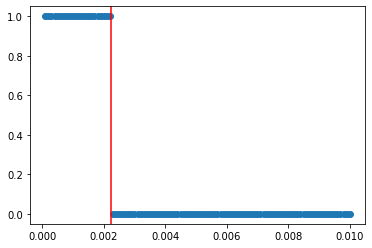

In [28]:
plt.scatter(dt_range, stability)
plt.axvline(max_dt, 0, 1, label='pyplot vertical line', c='r')
plt.show()

In [29]:
print(stability)
print(max_dt, dt_range[21], dt_range[22])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.0022222222222222222 0.0022 0.0023


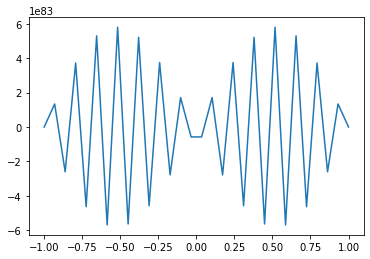

In [30]:
plt.plot(np.linspace(x_start, x_end, Nx), phi_approx[:, -1])
plt.show()

In [36]:
# Define the domain
x_start = -1
x_end = 1
x = x_end - x_start
Nx = 30
dx = x / Nx

max_dt = max_stable_timestep(dx, D)
dt = 1e-3
time_bounds = [0, 1]

D = 1
s = np.zeros(Nx)

g0 = 1 - (2 * D * dt / np.square(dx))
g_ = D * dt / np.square(dx)
G = sparse.diags([g_, g0, g_], [-1, 0, 1], shape=[Nx, Nx])

In [37]:
# Solve for the given conditions above with dt = 1e-2
def solve_phi(Nx, time_bounds, dt, dx, s):
    Nt = int((time_bounds[1] - time_bounds[0]) / dt)
    phi = np.zeros([Nx, Nt])
    phi[12:16] = 1
    
    g0 = 1 - (2 * D * dt / np.square(dx))
    g_ = D * dt / np.square(dx)
    G = sparse.diags([g_, g0, g_], [-1, 0, 1], shape=[Nx, Nx])
    
    time_elapsed = time_bounds[0]
    
    for i in range(Nt-1):
        # Do a forward time step
        phi[:, i+1] = G @ phi[:, i] + dt * s
        
        # Enforce the boundary conditions
        phi[0, i+1] = 0.
        phi[-1, i+1] = 0.
    
    return phi

In [38]:
phi_approx = solve_phi(Nx, time_bounds, dt, dx, s)

In [40]:
# Create an animation showing the diffusion of the alien bioweapon
fig, ax = plt.subplots(figsize=(10, 8.5))
line, = ax.plot(range(Nx), phi_approx[:, 0])
ax.set_ylim([-0.01, 1.1])

def animate(i):
    line.set_ydata(phi_approx[:, i])
    return line
    
frames = phi_approx.shape[1] - 1
anim = FuncAnimation(fig, animate, interval=10, frames=frames, repeat=False)
plt.close(fig)
HTML(anim.to_html5_video())  